# Курсовая работа "Фреймворк PyTorch для разработки искусственных нейронных сетей"

**2 часть работы: Подача изображения для распознавания**

### Импортируем необходимые библиотеки

In [ ]:
!pip install facenet_pytorch

In [ ]:
!pip install mediapipe

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode
import cv2
import os
import numpy as np

from facenet_pytorch import MTCNN
import mediapipe as mp
import torch
import torchvision.transforms as tt
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from pathlib import Path
from google.colab import drive

### Модуль для создания фото

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Делаем фотографию:

In [ ]:
#from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable


Сохраняем и отображаем:

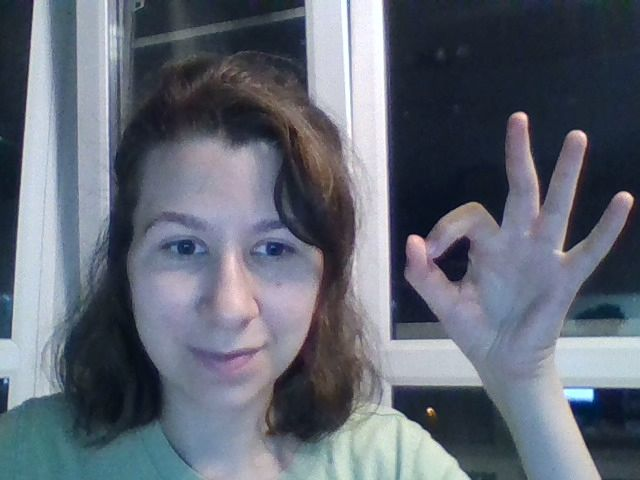

In [ ]:
img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

### Инициализуем модели для трекинга лиц и жестов

In [ ]:
mp_face_detection = mp.solutions.face_detection
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

In [ ]:
face_detection = mp_face_detection.FaceDetection()
hand_tracking = mp_hands.Hands()

In [ ]:
filename = 'photo.png'

In [ ]:
# считываем
image_path = os.path.join(filename)
image = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)

# преобразуем изображение в ргб
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# поиск лица
face_results = face_detection.process(image_rgb)
if face_results.detections:
    for detection in face_results.detections:
        # извлекаем координаты границ
        bbox = detection.location_data.relative_bounding_box
        h, w, c = image.shape
        x, y, width, height = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)

        # поиск лица
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)

# поиск рук
hand_results = hand_tracking.process(image_rgb)
if hand_results.multi_hand_landmarks:
    for hand_landmarks in hand_results.multi_hand_landmarks:
        # отрисовка найденного
        mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)


# отображение результата
cv2.imwrite('pic22.jpg', image)


True

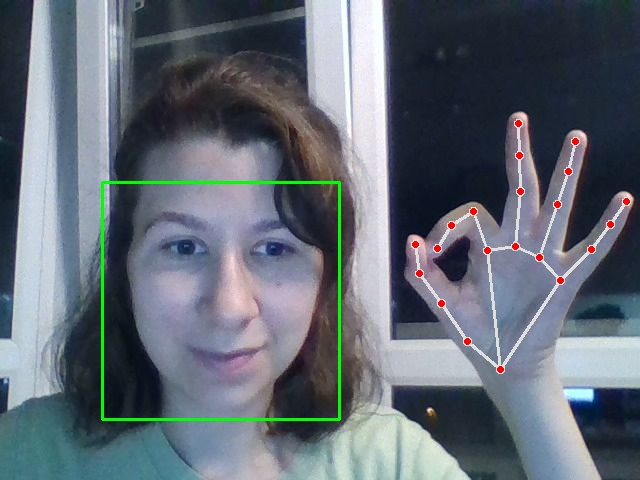

In [ ]:
img = cv2.imread('pic22.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Возьмем только руку:

In [ ]:
# считываем
image_path = os.path.join(filename)
image = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)

# преобразуем изображение в ргб
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# поиск лица
face_results = face_detection.process(image_rgb)
if face_results.detections:
    for detection in face_results.detections:
        # извлекаем координаты границ
        bbox = detection.location_data.relative_bounding_box
        h, w, c = image.shape
        x, y, width, height = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)

#         # поиск лица
#         cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)

# поиск рук
hand_results = hand_tracking.process(image_rgb)
if hand_results.multi_hand_landmarks:
    for hand_landmarks in hand_results.multi_hand_landmarks:
        # отрисовка найденного
        x_max = 0
        y_max = 0
        x_min = w
        y_min = h
        for lm in hand_landmarks.landmark:
            x, y = int(lm.x * w), int(lm.y * h)
            if x > x_max:
                x_max = x + 50
            if x < x_min:
                x_min = x - 30
            if y > y_max:
                y_max = y + 70
            if y < y_min:
                y_min = y - 20
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 0), 2)
        #mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)


# отображение результата
cv2.imwrite('pic33.jpg', image)


True

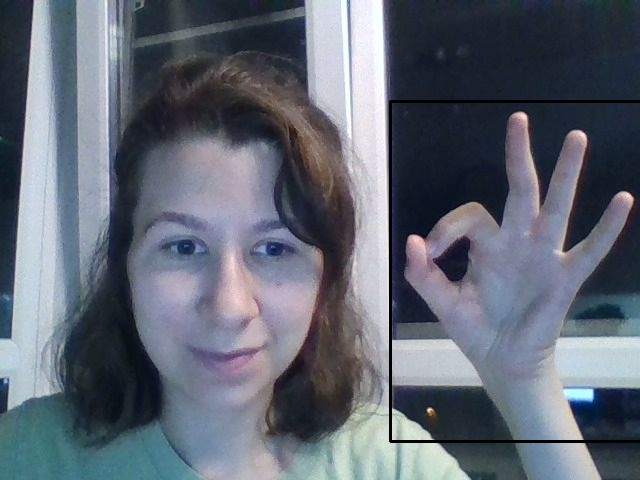

In [ ]:
img = cv2.imread('pic33.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

### Вырежем руку из изображения

In [ ]:
h = y_max - y_min
w = x_max - x_min

In [ ]:
hand = img[y_min:y_min+h,x_min:x_min+w]

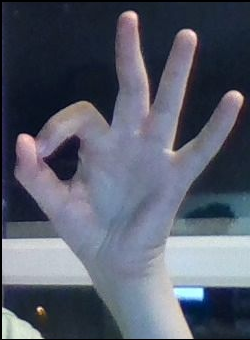

In [ ]:
cv2_imshow(hand)

In [ ]:
cv2.imwrite('hand.jpg', hand)

True

### Очистка изображения от заднего фона

In [ ]:
# инициализация и загрузка изображения
# до этого размера по минимальной стороне
# мы будем уменьшать изображение
smallestSideSize = 500
# размер прямоугольника для фона (отступ от внешней стороны изображения)
# в процентах от размера изображения
mainRectSize = .04 # 4%
# размер прямоугольника для переднего плана
# будет размещен в центре изображения
fgSize = .15 # 15%

In [ ]:
def quantify_colors(img, k=32, attempts=5):
    # преобразуем пиксели во float
    float_pixels = np.float32(img)
    # "Вытягиваем 2-мерный массив в 1-мерный"
    float_pixels = float_pixels.reshape((float_pixels.shape[0] * float_pixels.shape[1], 3))
    # применяем метода k-средних
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(float_pixels, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
    # Преобразуем пиксели обратно в uint
    center = np.uint8(center)
    # "закрашиваем" и восстанавливаем 2-мерность массива
    ret = center[label.flatten()]
    ret = ret.reshape(img.shape)
    return ret

In [ ]:
# Создаем пустую маску
mask = np.zeros(hand.shape[:2], np.uint8)

# Создаем прямоугольник фона
bg_w = round(h * mainRectSize)
bg_h = round(w * mainRectSize)
bg_rect = (bg_w, bg_h, h - bg_w, w - bg_h)

# Создаем прямоугольник переднего плана
fg_w = round(w * (1 - fgSize) / 2)
fg_h = round(h * (1 - fgSize) / 2)
fg_rect = (fg_w, fg_h, w - fg_w, h - fg_h)

# Рисуем на маске закрашенный прямоугольник с сигналом что это передний план (объект)
cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# инициализируем массивы для моделей
bgdModel1 = np.zeros((1, 65), np.float64)
fgdModel1 = np.zeros((1, 65), np.float64)
# Первый запуск
cv2.grabCut(hand, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
# Рисуем рамку "возможно фон"
cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
# Второй запуск
cv2.grabCut(hand, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)
# строим итоговую маску по которой будем вырезать фон с изображения
# значения 1 и 3 ("передний план" и "возможно передний план") будем оставлять на итоговом
# изображении. Все остальное будет удалено
mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')

In [ ]:
unique, counts = np.unique(mask_result, return_counts=True)
mask_dict = dict(zip(unique, counts))

if mask_dict[0] > mask_dict[255] * 1.6:
    mask_result = np.where((mask == 0) + (mask != 1) + (mask != 3), 255, 0).astype('uint8')

In [ ]:
# "выжигаем" маску на изображение
masked = cv2.bitwise_and(hand, hand, mask=mask_result)
# для себя я выбрал синий фон в качестве хрома-кея
masked[mask_result < 2] = [0, 0, 0]

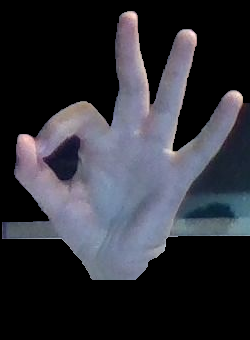

In [ ]:
cv2_imshow(masked)

### Дорисовывание черных границ

In [ ]:
image = cv2.copyMakeBorder(masked, 50, 50, 50, 50, borderType=cv2.BORDER_CONSTANT)

In [ ]:
# dsize
dsize = (128, 128)
# resize image
output = cv2.resize(image, dsize)


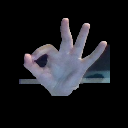

In [ ]:
cv2_imshow(output)

### Перевод изображения в черно-белое

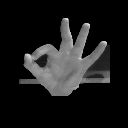

In [ ]:
gray_hand = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_hand)

### Загрузка сохраненной модели для классификации жестов

In [ ]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
net = torch.load('/drive/MyDrive/GB/Pytorch/gesture_detection_model.pth')
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
classes_train = ['09_c', '10_down', '03_fist', '05_thumb', '04_fist_moved', '02_l', '08_palm_moved', '06_index', '07_ok', '01_palm']

In [ ]:
# функция для переименовывания класса
def digit_to_classname(digit):
    for idx, itm in enumerate(classes_train):
        if idx == digit:
            return itm

### Перевод изображения в тензор

In [ ]:
im = Image.fromarray(np.uint8(cm.gist_earth(gray_hand)*255))

In [ ]:
data_transforms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])


# Convert the image to PyTorch tensor
img = data_transforms(im)
print(img)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [ ]:
img.shape

torch.Size([3, 128, 128])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Предсказание

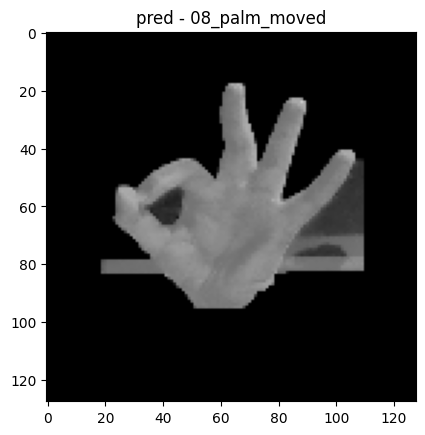

In [ ]:
with torch.no_grad():
  picture = img.to(device)
  res = net(picture[None, ...])
  plt.title(f'pred - {digit_to_classname(res[0].argmax())}')
  plt.imshow(img.permute(1, 2, 0), cmap='gray')
  plt.show()

К сожалению у модели не получается точно предсказать жесты на изображении. Предобработка изображений пока не помогает. Видимо нужно искать другие варианты для предобработки.